In [ ]:
!git clone https://github.com/congnghia0609/ntc-scv.git
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

In [34]:
import os
import pandas as pd
import time
import numpy as np

import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import tqdm as notebook_tqdm

LOAD DATA

In [4]:
def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, 'r', encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            elif label == "pos":
                label = 1
            data = {
                "sentence": sentence,
                "label": label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [5]:
folder_path = {
    "train": "./data/data_train/train",
    "valid": "./data/data_train/test",
    "test": "./data/data_test/test"
}

train_df = load_data_from_path(folder_path["train"])
valid_df = load_data_from_path(folder_path["valid"])
test_df = load_data_from_path(folder_path["test"])

PREPROCESSING

In [6]:
!pip install langid

In [7]:
from langid.langid import LanguageIdentifier, model

def identify_language(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["sentence"])
        if score[0]  != "vi" or (score[0] == "vi" and score[1] < THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

train_df_vi, train_df_other = identify_language(train_df)

In [8]:
import re
import string

# Remove URLs, HTML tags, special characters, and emojis
def preprocess_text(text):
    url_pattern = re.compile(r'https?://\s+\www\.\s+')
    text = url_pattern.sub(r' ', text)

    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(r' ', text)

    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, ' ')
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F" # emotions
        u"\U0001F300-\U0001F5FF" # symbols & pictographs
        u"\U0001F680-\U0001F6FF" # transport & map symbols
        u"\U0001F1E0-\U0001F1FF" # flags (iOS)
        u"\U0001F1E6-\U0001F1FF" # flags (iOS)
        u"\U00002702-\U000027B0" # dingbats
        u"\U000024C2-\U0001F251" # enclosed characters
        u"\U0001f926-\U0001f937" # people
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE                    
    )
    text = emoji_pattern.sub(r' ', text)
    text = " ".join(text.split())
    return text.lower()

In [9]:
train_df_vi["preprocess_sentence"] = [
    preprocess_text(row["sentence"]) for index, row in train_df_vi.iterrows()
]

valid_df["preprocess_sentence"] = [
    preprocess_text(row["sentence"]) for index, row in valid_df.iterrows()
]

test_df["preprocess_sentence"] = [
    preprocess_text(row["sentence"]) for index, row in test_df.iterrows()
]

/tmp/ipykernel_8452/2601355720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi["preprocess_sentence"] = [


In [10]:
train_df_vi

,sentence,label,preprocess_sentence
0,Mua có mỗi Bingsu thập_cẩm 45k mà mình f đợi h...,0,mua có mỗi bingsu thập cẩm k mà mình f đợi hơn...
1,Thứ 6 nào ta cùng quẩy 💣 💣 💣\n Vuvuzela beer c...,0,thứ nào ta cùng quẩy vuvuzela beer club chung ...
2,"Mình đi với nhóm , tổng_cộng 4 người ăn chỉ có...",0,mình đi với nhóm tổng cộng người ăn chỉ có khô...
3,"nhân_viên phục_vụ không mấy tận_tình , đồ_ăn r...",0,nhân viên phục vụ không mấy tận tình đồ ăn ra ...
4,"Vào đây thì hết bàn , nhưng mình vẫn ngồi đợi ...",0,vào đây thì hết bàn nhưng mình vẫn ngồi đợi bì...
...,...,...,...
29995,2-9 mình đi với nhóm bạn tổng_cộng là 8ng.Thiệ...,1,mình đi với nhóm bạn tổng cộng là ng thiệt hại...
29996,sushi bình_dân mà chất_lượng không bình_dân ch...,1,sushi bình dân mà chất lượng không bình dân ch...
29997,Trời_ơi từ bé đến lớn chưa thử món kem nào bằn...,1,trời ơi từ bé đến lớn chưa thử món kem nào bằn...
29998,Nge mn cũng ns ngon nên hni đến coi thế_nào .\...,1,nge mn cũng ns ngon nên hni đến coi thế nào qu...


In [11]:
!pip install torchtext==0.16.0

VECTORIZATION

In [12]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

# Create iter dataset
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

# Build vocab
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi["preprocess_sentence"], tokenizer=tokenizer),
    specials=["<unk>", "<pad>"],
    max_tokens=vocab_size,
)
vocabulary.set_default_index(vocabulary["<unk>"])

# Convert iter into torchtext dataset
from torchtext.data.functional import to_map_style_dataset
def prepare_dataset(df):
    for index, row in df.iterrows():
        sentence = row["preprocess_sentence"]
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row["label"]
        yield encoded_sentence, label

In [ ]:
# 4. Saving the vocabulary
vocab_save_path = "./my_vocabulary.pth"
print(f"\nSaving vocabulary to: {vocab_save_path}")
torch.save(vocabulary, vocab_save_path)
print("Vocabulary saved successfully.")

# 5. Loading the vocabulary
print(f"\nLoading vocabulary from: {vocab_save_path}")
loaded_vocabulary = torch.load(vocab_save_path)
print("Vocabulary loaded successfully.")


Saving vocabulary to: ./my_vocabulary.pth
Vocabulary saved successfully.

Loading vocabulary from: ./my_vocabulary.pth
Vocabulary loaded successfully.


In [13]:
train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

DATALOADER

In [24]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    encoded_sentences, labels = [], []
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)

    labels = torch.tensor(labels, dtype=torch.int64)
    encoded_sentences = pad_sequence(
        encoded_sentences,
        padding_value=vocabulary["<pad>"],
    )

    return encoded_sentences, labels

In [20]:
BATCH_SIZE = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch,
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch,
)  

MODEL

In [35]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, kernel_sizes, num_filters, num_classes):
        super(TextCNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=k, stride=1) for k in kernel_sizes
        ])
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)
    
    def forward(self, x):
        batch_size, sequence_length = x.shape
        x = self.embedding(x.T).transpose(1, 2)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(x)
        return x

TRAINING EVALUATION FUNCTION

In [36]:
# Training
def train(
        model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50
):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero grad
        optimizer.zero_grad()

        # Predictions
        predictions = model(inputs)

        # Compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # Backward
        loss.backward()
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        losses.append(loss.item())

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                f"epoch {epoch:3d} | batch {idx:5d}/{train_dataloader:5d} | "
                f"accuracy {(total_acc / total_count):8.3f} | "
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

        epoch_acc = total_acc / total_count
        epoch_loss = sum(losses) / len(losses)
        return epoch_acc, epoch_loss
    
# Evaluation
def evaluate(
        model, criterion, device, valid_dataloader
):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Predictions
            predictions = model(inputs)

            # Compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)
        epoch_acc = total_acc / total_count
        epoch_loss = sum(losses) / len(losses)
        return epoch_acc, epoch_loss

TRAINING

In [38]:
NUM_CLASS = 2
vocab_size = len(vocabulary)
embedding_dim = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=NUM_CLASS
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 10
save_model = "./model"

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    # Train
    train_acc, train_loss = train(
        model,
        optimizer,
        criterion,
        train_dataloader,
        DEVICE,
        epoch=epoch,
    )
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(
        model,
        criterion,
        DEVICE,
        valid_dataloader
    )
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    if best_loss_eval > eval_loss:
        torch.save(model.state_dict(), save_model + "/text_cnn_model.pt")

    print("-"*59)
    print(
        f"epoch {epoch:3d} | "
        f"time {time.time() - epoch_start_time:5.2f}s | "
        f"train accuracy {train_acc:8.3f} | "
        f"train loss {train_loss:8.3f} | "
        f"valid accuracy {eval_acc:8.3f} | "
        f"valid loss {eval_loss:8.3f} | "
    )
    print("-"*59)
    model.load_state_dict(torch.load(save_model + "/text_cnn_model.pt"))
    model.eval()

-----------------------------------------------------------
epoch   1 | time  0.79s | train accuracy    0.430 | train loss    0.790 | valid accuracy    0.501 | valid loss    0.730 | 
-----------------------------------------------------------
-----------------------------------------------------------
epoch   2 | time  0.79s | train accuracy    0.461 | train loss    0.751 | valid accuracy    0.501 | valid loss    0.733 | 
-----------------------------------------------------------
-----------------------------------------------------------
epoch   3 | time  0.76s | train accuracy    0.523 | train loss    0.728 | valid accuracy    0.531 | valid loss    0.684 | 
-----------------------------------------------------------
-----------------------------------------------------------
epoch   4 | time  0.62s | train accuracy    0.602 | train loss    0.669 | valid accuracy    0.654 | valid loss    0.657 | 
-----------------------------------------------------------
----------------------------

TEST

Test accuracy: 0.698
Test loss: 0.605


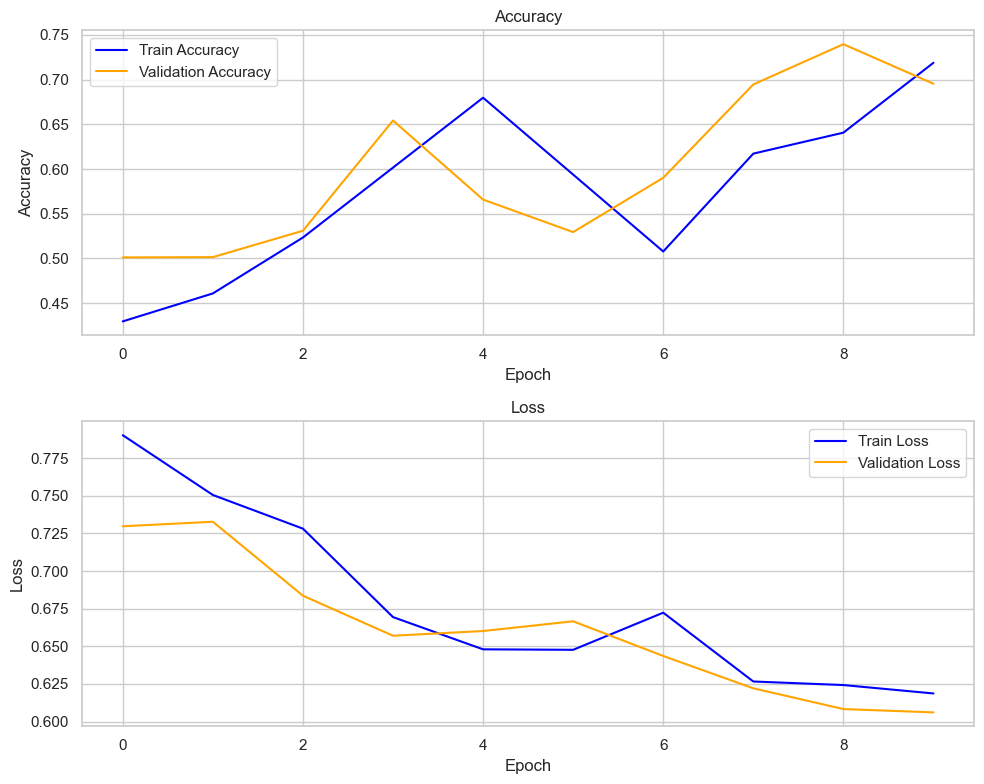

In [40]:
test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch,
)

test_acc, test_loss = evaluate(model, criterion, DEVICE, test_dataloader)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
def plot_metrics(train_accs, train_losses, eval_accs, eval_losses):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(train_accs, label="Train Accuracy", color="blue")
    ax[0].plot(eval_accs, label="Validation Accuracy", color="orange")
    ax[0].set_title("Accuracy")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()

    ax[1].plot(train_losses, label="Train Loss", color="blue")
    ax[1].plot(eval_losses, label="Validation Loss", color="orange")
    ax[1].set_title("Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend()

    plt.tight_layout()
    plt.show()
plot_metrics(train_accs, train_losses, eval_accs, eval_losses)